# Graph Analysis

In [68]:
import pandas as pd
import numpy as np
from src.basic_project import preprocessing, extract_data, BasicModel
from gensim.matutils import corpus2dense, corpus2csc
from gensim.corpora import Dictionary
#from gensim.models.wrappers import LdaMallet
#------------------------------------------
#   Librerías para Semantic graphs
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from collections import Counter
from gensim.models.ldamodel import LdaModel
import random
#import fa2
from scipy.sparse import triu


### LDA embedding

In [139]:
def embedding(texts,num_topics):
    # Create a corpus
    D = Dictionary([s.split(' ') for s in texts])
    n_tokens = len(D)
    reviews_bow = [D.doc2bow(doc.split(' ')) for doc in texts]
    # compute using a LDA algorithm for topic modelling with 200 topics.
    ldag = LdaModel(corpus=reviews_bow, id2word=D, num_topics=num_topics)
    return ldag, reviews_bow

In [140]:
texts, labels, costs, contributions = extract_data('data/projects.xlsx', 'data/SciVocCodes.xlsx')
texts = preprocessing(texts)

In [109]:
ldag, reviews_bow = embedding(texts,60)

In [141]:
corpus_size = len(reviews_bow)
print(f"Dataset contains {corpus_size} documents")

Dataset contains 32052 documents


Nota: Observamos que tiene 32.052 documentos. Dado que es un numero muy alto, para hacer el análisis de los grafos limitaremos el número de documentos a analizar a unos 1000 documentos.

In [197]:
num_docs = 1000
corpus = random.sample(reviews_bow, num_docs)
print(f"Dataset contains {len(corpus)} documents")

Dataset contains 1000 documents


In [148]:
corpus_ldag = ldag[corpus]
X = corpus2csc(corpus_ldag).T

In [149]:
n_topics = X.shape[1]
print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {X.nnz} nonzero values out of {num_docs * n_topics}")

Number of topics: 60
X: sparse matrix with 9263 nonzero values out of 60000


In [150]:
# Note that the embedding is shown in sparse format, showing the non-zero values only. The proportion of zero entries is
print(f"{(1 - X.nnz / num_docs / n_topics) * 100:.2f} % ")

84.56 % 


In [151]:
# All other entries are values in  [0,1] . 
# Since the embedding space is probabilistic the row vectors should sum up to one. 
# However, we can check that this is no exactly the case: 
average_row = np.mean(X.sum(axis=1).T)
print(f"Average row sum: {average_row:.2f}")
if average_row != 1.0: # If the row of vectros are not sum to one, we need to normalize this.
    X = scsp.csr_matrix(X / np.sum(X, axis=1))
average_row = np.mean(X.sum(axis=1).T)
print(f"Average row sum after normalization: {average_row:.2f}")

Average row sum: 0.98
Average row sum after normalization: 1.00


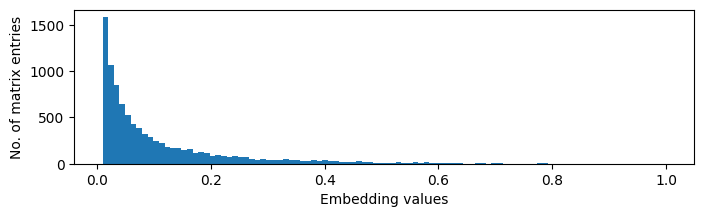

In [152]:
plt.figure(figsize=(8, 2))
plt.hist(X.data, bins=100)
plt.xlabel('Embedding values')
plt.ylabel('No. of matrix entries')
plt.show()

### Semantic Similarity Measures

In order to construct a semantic graph from a collection of document embeddings, a similary measure between two embeddings,  𝐱  and  𝐲 , is required.

To do this, we define differents steps:

1. Determine the most and the least similar documents in the dataframe, according to the BC similarity measure.
2. Compute the indices of the least similar and the most similar documents in the dataframe (excluding the document itself).
3. Compute a similarity matrix  𝐒 for a similarity graph.


##### 1. Similarity between documents

In [153]:
# Función que nos devuelve la similitud de los documentos con el documento i
def similarity_docs(i,X): 
    xi = X[i, :]
    return np.multiply(np.sqrt(xi),np.sqrt(X[1:].T)) # Excluimos el elemento i

In [154]:
# Similitud con el documento 0
print(similarity_docs(0,X))

  (0, 882)	0.03257891515463529
  (0, 878)	0.03766165746564183
  (0, 822)	0.10490580865175621
  (0, 813)	0.12641581487909237
  (0, 687)	0.04057287245151015
  (0, 644)	0.12703974577506982
  (0, 601)	0.03947351332466421
  (0, 513)	0.1520069274150612
  (0, 490)	0.1149438928495389
  (0, 469)	0.11906650176794903
  (0, 441)	0.03056333724858058
  (0, 300)	0.13863861330648555
  (0, 210)	0.16580325126349063
  (0, 183)	0.03697660455583111
  (0, 157)	0.03601436177103754
  (0, 78)	0.022451181923103036
  (0, 76)	0.07223434715611968
  (0, 51)	0.025007434765248353
  (0, 28)	0.11712423683735135
  (0, 20)	0.07305436566187226
  (0, 15)	0.12023913983477619
  (0, 5)	0.05680994890546562
  (0, 986)	0.030330529872104973
  (0, 939)	0.022478725537926927
  (0, 845)	0.06773567139901465
  :	:
  (0, 136)	0.40557361120472357
  (0, 132)	0.2770683915002984
  (0, 130)	0.3351977702060116
  (0, 126)	0.2688902724629111
  (0, 119)	0.4107455095555676
  (0, 115)	0.6534869881626595
  (0, 111)	0.5487761758713473
  (0, 106)	0.6

In [155]:
BC = similarity_docs(0,X)
arg_max = np.argmax(BC)
print('Most similar: ',arg_max)
arg_min = np.argmin(BC)
print('Least similar: ',arg_min)

Most similar:  608
Least similar:  0


##### 2. Compute the similarity matrix S based on the BC.

In [156]:
S = np.multiply(np.sqrt(X),np.sqrt(X.T))

print('Number of nonzero:',S.nnz)
print(f"NON-ZERO proportion = {(S.nnz/(S.shape[0]*S.shape[1]))*100:0.2f} %")

Number of nonzero: 819880
NON-ZERO proportion = 81.99 %


Note that the matrix is symmetric so we keep only with upper triangular part

In [157]:
S = triu(S,k = 1) # above diagonal
print('Number of non-zero components in S:', S.nnz )

Number of non-zero components in S: 409440


### Semantic Graph

Para la representación de los grafos seguiremos, hemos optado por seguir los siguientes pasos:

1. Graph construction
2. Visualize Graphs with layout algorithms
3. Visualize Graphs with Community detection algorithms
4. Impact

##### 1. Graph Construction

In [158]:
n_nodes = num_docs                                  # the documents in the corpus
n_edges = S.nnz                                     # links connecting pairs of documents with nonzero similarity 
n_edges_per_node = np.round(n_edges/n_nodes)        #  the similarity values ---> Comprobar esto!!!

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")
      

Number of nodes: 1000
Number of edges: 409440
Number of edges per node: 409.0


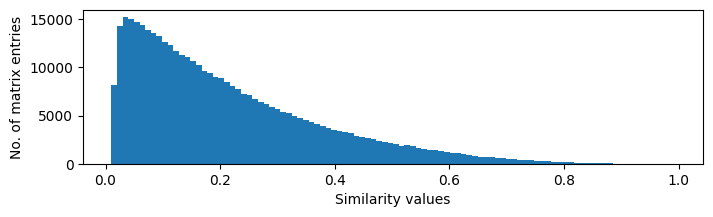

In [159]:
plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

1.1 Apply a threshold to sparse matrix in order to get a subgraph with an average of 10 edges per node.

In [160]:
# Set average number of edges per node
n_edges_per_node = 10
sample_factor = num_docs / corpus_size

# Compute threshold to get the target number of edges

n_edges = n_nodes * n_edges_per_node
sort = np.sort(S.data)
inv_sort = sort[::-1]
thr = inv_sort[n_edges]

# Apply the threshold to similarity matrix
S.data[S.data<thr] = 0
S.eliminate_zeros()

n_links = len(S.data)/2/sample_factor**2

print(f"Threshold: {thr:.4f}")
print(f"Number of edges: {n_edges}")
print(f"Estimated number of links in full corpus: {n_links:.2f}")

Threshold: 0.6210
Number of edges: 10000
Estimated number of links in full corpus: 5137167.19


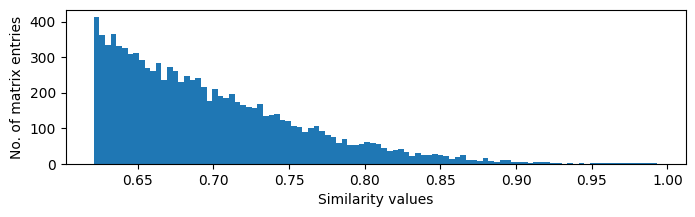

In [161]:
# New visualization after apply threshold

plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.xlabel('Similarity values')
plt.ylabel('No. of matrix entries')
plt.show()

##### 2. Layout Algorithms

In [162]:
G = nx.from_scipy_sparse_matrix(S)

/var/folders/z8/52zfs8h97qj1h6xxcnn1r3mh0000gn/T/ipykernel_40487/499930988.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(S)


2.1 Testing Random Layout

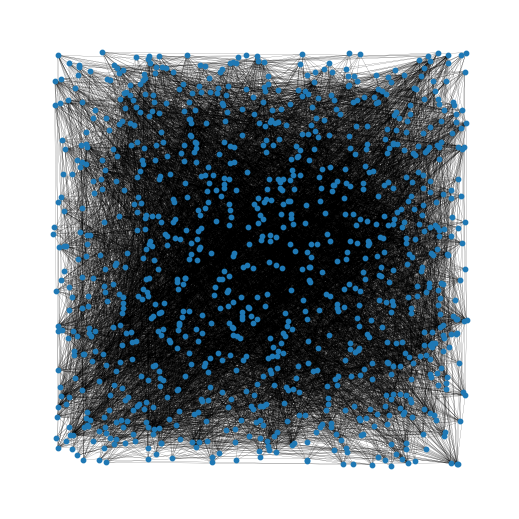

In [163]:
# ##########################
# Testing a random  layout #
# ##########################

positions = nx.drawing.layout.random_layout(G)
plt.figure(figsize=(5,5))
nx.draw(G, positions, node_size=10, width=0.10)

2.2 Testing a Fruchterman-Reingold: Forced-directed algorithm

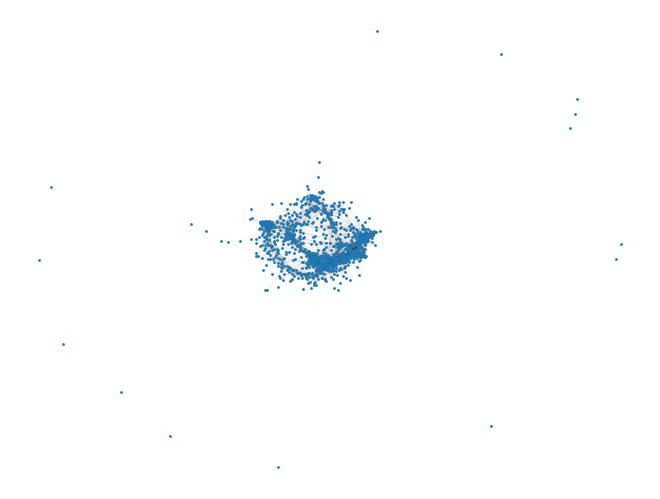

In [ ]:
########################################################################
#       Testing a Fruchterman-Reingold: Forced-directed algorithm      #
########################################################################
# Compute positions
positions = nx.spring_layout(G, iterations = 50, seed = 0)

# Draw graph
nx.draw(G, positions, node_size=1, width=0.02)

2.3 Largest connected component (LCC)

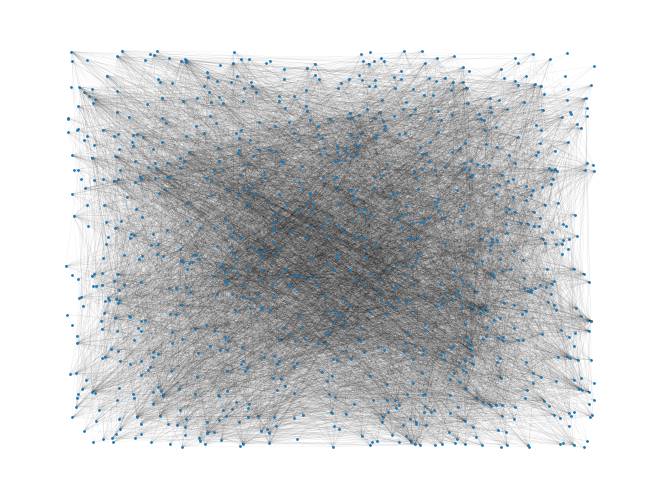

In [ ]:
########################################################################
#           Largest connected component (LCC) from the graph           #
########################################################################

largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc) # saving LCC in a subgraph
nx.draw(G_lcc, positions, node_size=1, width=0.02)

2.4 FALTAAAA

In [ ]:
# Compute positions using layout algorithm
gravity = 50
# Create layout object
layout = fa2.ForceAtlas2(gravity=gravity)

# Compute node positions using forceatlas2_networkx_layout method.
positions = layout.forceatlas2_networkx_layout(G_lcc, iterations=200)
nx.draw(G_lcc, positions, node_size=1, width=0.02)

##### 3. Community detection

3.1 Define community algorith to detect communities

In [174]:
import networkx.algorithms.community as nx_comm

# Compute communities
C = nx_comm.greedy_modularity_communities(G_lcc, resolution=2)

# Modularity of the partition
modularity = nx_comm.modularity(G_lcc, C)

nc = len(C)
print(f"Number of communities: {nc}")
print(f"Modularity: {modularity:.2f}")

Number of communities: 12
Modularity: 0.68


3.2 Check that the size of the communities.

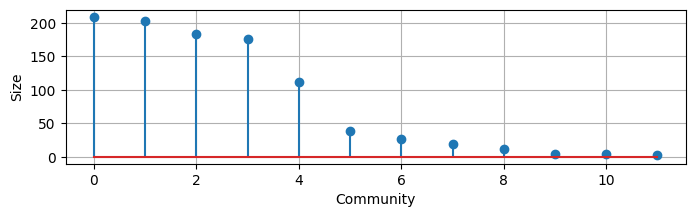

In [175]:
# Sort communities by decreasing size
C = sorted(C, key=len, reverse=True)
# Number of communities
nc = len(C)

# Size of each community
comm_sizes = [len(x) for x in C]

plt.figure(figsize=(8, 2))
plt.stem(range(nc), comm_sizes)
plt.xlabel('Community')
plt.ylabel('Size')
plt.grid('on')
plt.show()

3.3 Draw graph with color palette to show the differents communities

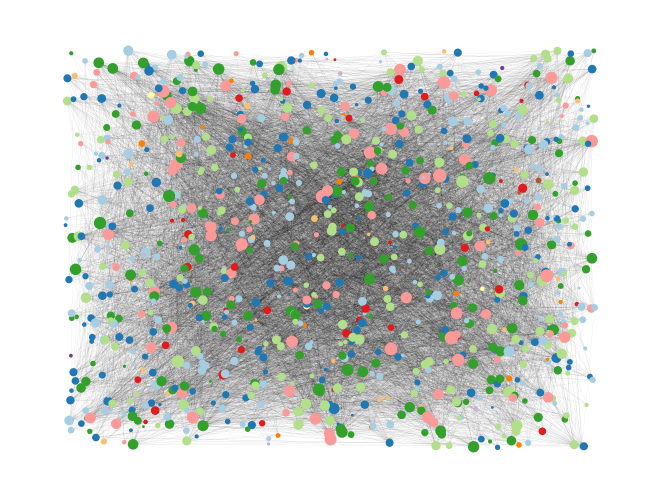

In [176]:
palette = sns.color_palette(palette="Paired", n_colors=nc)
node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

# Map node attribute to rgb colors
node_colors = [palette[node2comm[node]] for node in G_lcc]

# Get list of degrees
degrees = [degree[1] for degree in G_lcc.degree]

#  Draw graph
nx.draw(G_lcc, positions, node_size=degrees, width=0.02, 
        node_color=node_colors)

**NOTA**
TAL VEZ Y SOLO TAL VEZ --> La dispersión de las comunidades viene dado por la elección random de los 1000 documentos --> Enforcarlo de manera diferente 

3.4 Quality Metrics

In [177]:
coverage, performance = nx_comm.partition_quality(G_lcc, C)

print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Coverage: 0.8657134286571343
Performance: 0.8476436610001956


3.5 Community networks

In [178]:
# Convert matrix to csr
S2 = scsp.csr_matrix(S + S.T)

# Initialize matrix for the community graph
M = np.zeros((nc, nc))

# Loop over the communities
for i in range(nc):
    nodes_i = list(C[i])
    ni = len(nodes_i)
    
    # Loop over the communities
    for j in range(i+1, nc):
        nodes_j = list(C[j])
        n_j = len(nodes_j)

        # Select submatrix Sij, with rows from Ci and columns from Cj
        Sij = S2[nodes_i][:, nodes_j] 
        
        # Compute M
        M[i, j] = (1/(ni*n_j))*np.sum(np.sum(Sij))

In [179]:
CG = nx.from_numpy_matrix(M)
positions_CG = nx.spring_layout(CG, iterations = 50, seed = 0)

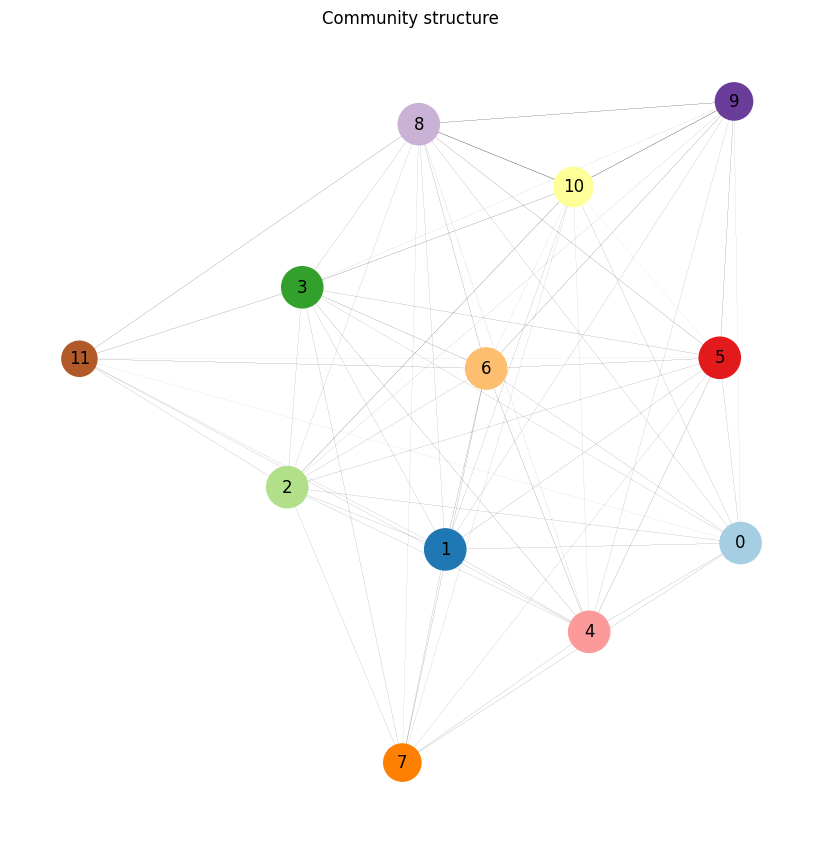

In [181]:
# Compute edge widths
w = [e[2]['weight']*5 for e in CG.edges(data=True)]
# Compute node sizes
degrees = [val * 80 for (node, val) in CG.degree()]

plt.figure(figsize=(8,8))
nx.draw(CG, positions_CG, node_size=degrees, width=w, node_color=palette, with_labels=True)
plt.title("Community structure")
plt.show()

##### 4. Impact

In this section we will explore measures to evaluate the role of a node in its network, using a family of centrality measures, that evaluate nodes according to their position in the graph.

In [186]:
def print_top3_nodes(impact):
    # Compute top 3 nodes
    sorted_ctr = sorted(impact, key=lambda x: x[1], reverse=True)
    ctr_top3 = sorted_ctr[2][1]
    print(ctr_top3)

    # Highlight top nodes with a larger node size
    eps = 1e-5
    node_sizes = [20 * x[1] / ctr_top3 * (x[1] > ctr_top3 - eps) for x in impact]

    # Plot graph
    plt.figure(figsize=(4, 4))
    nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)

4.1 Degree centrality.

In [188]:
# Compute centrality
centrality = [(k, v) for k, v in nx.degree_centrality(G_lcc).items()]

# Print the sum of all centrality values:
sum_gw = np.sum(list(nx.degree_centrality(G_lcc).values()))
print(f"Sum of all graph weights: {sum_gw:.2f}")

Sum of all graph weights: 20.31



Print the top 3 nodes with the highest centrality:

0.07309644670050762


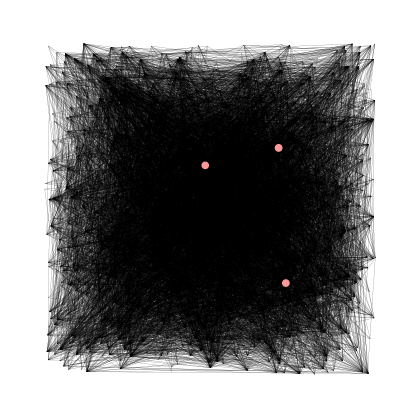

In [189]:
print_top3_nodes(centrality)

4.2 Closeness

In [190]:
dict_edges = nx.get_edge_attributes(G_lcc, 'weight')

edges = {}
for k, v in dict_edges.items(): edges[k] = v

nx.set_edge_attributes(G_lcc, edges, 'distance')

# Compute centrality
centrality = nx.closeness_centrality(G_lcc, distance = 'distance')

0.4388470781559579


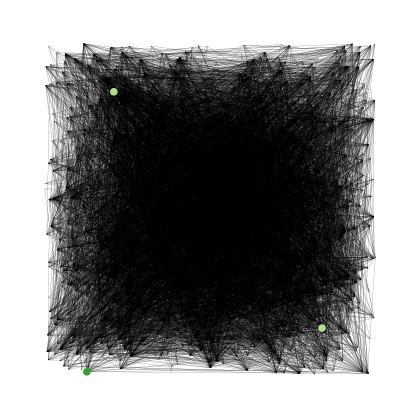

In [191]:
print_top3_nodes(centrality.items())

4.3 Betweenness

0.023555626521283485


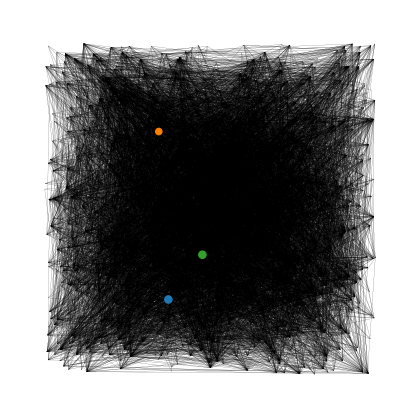

In [194]:
# Compute centrality
centrality = nx.betweenness_centrality(G_lcc)
print_top3_nodes(centrality.items())

4.4 PageRank

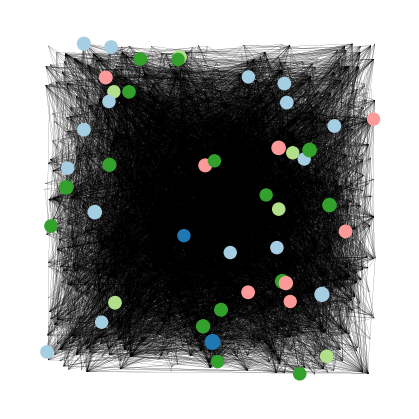

In [195]:
centrality = nx.pagerank(G_lcc)
node_sizes = [40000 * x * (x > 0.00185) for x in centrality.values()]
plt.figure(figsize=(4,4))
nx.draw(G_lcc, positions, node_size=node_sizes, node_color=node_colors, width=0.1)